In [86]:
import tensorflow as tf
import os #Navigate through file structures


In [87]:
tf.config.experimental.list_physical_devices()


[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

In [88]:
# Avoiding Out of Memory Error by setting and limiting  GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [125]:
import cv2 #Computer vision


In [90]:
#To check the folders present
os.listdir(r'C:\Users\PC\Documents\Data-Science-Tasks\Malaria-ImageCLassification\cell_images')

['Parasitized', 'Uninfected']

In [91]:
tf.data.Dataset.list_files

<function tensorflow.python.data.ops.dataset_ops.DatasetV2.list_files(file_pattern, shuffle=None, seed=None, name=None) -> 'DatasetV2'>

In [92]:
import numpy as np
from matplotlib import pyplot as plt

In [121]:
tf.keras.utils.image_dataset_from_directory(r'C:\Users\PC\Documents\Data-Science-Tasks\Malaria-ImageCLassification\cell_images', batch_size=64)

Found 27558 files belonging to 2 classes.


<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [94]:
#Building an image dataset
data = tf.keras.utils.image_dataset_from_directory(r'C:\Users\PC\Documents\Data-Science-Tasks\Malaria-ImageCLassification\cell_images')

Found 27558 files belonging to 2 classes.


In [122]:
data_iterator = data.as_numpy_iterator()
data_iterator

NumpyIterator(iterator=<tensorflow.python.data.ops.iterator_ops.OwnedIterator object at 0x0000018A3C8D7140>)

In [123]:
#Gets another batch from the iterator
batch = data_iterator.next()
len(batch)

2

In [124]:
# Images represented as numpy arrays
batch[0].shape

(32, 256, 256, 3)

In [98]:
# Class 0 equals Parasatized
# Class 1 equals Uninfected
batch[1].max

<function ndarray.max>

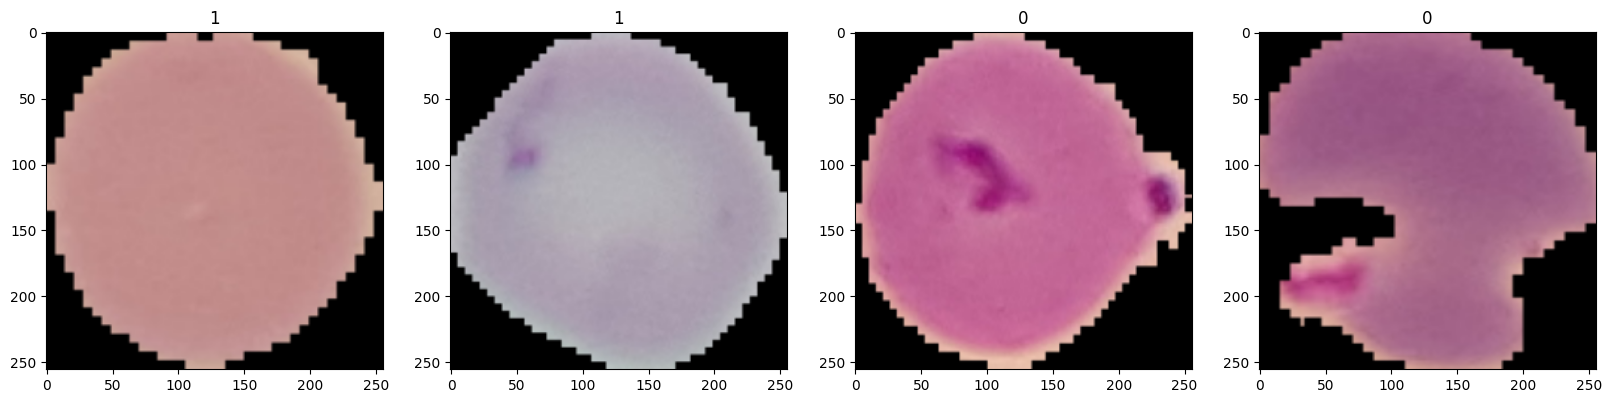

In [99]:
#Using matplotlib to plot out 4 images at the same time
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

In [100]:
scaled = batch[0] /255

In [101]:
scaled.min()

0.0

# Pre processing Data

This section will involve scaling the image values to between 0 and 1 instead of 25,500 images.
This will help the Deep Learning Models generalize faster and produce better results.
Also, I will split the data into three sections to ensure I dont overfit:
1. Training
2. Testing
3. Validation

In [102]:
# Scaling the Data
data = data.map(lambda x, y: (x/255, y))


In [103]:
#data.as_numpy_iterator().next()[1]

In [104]:
#scaled_iterator = data.as_numpy_iterator()

In [105]:
#The images are between 0 and 1
#scaled_iterator.next()[1].max()

In [106]:
#862 Batches and each batch has 32 images. 862 * 32 = 27584 images
len(data)

862

In [107]:
#Establishing training data sizes, allocating data to each of the partitions
# Ratio of 60%, 20%, 20%

train_size = int(len(data)*.6)
val_size = int(len(data)*.2)
test_size = int(len(data)*.2)+1

In [108]:
train_size + val_size + test_size

862

In [109]:
train = data.take(train_size) 
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

In [110]:
len(val)

172

In [111]:
len(test)

173

In [112]:
len(train)

517

# Deep Model

Deep modelling using the Keras sequential model API 
Build a deep learning model

In [113]:
from tensorflow.keras.models import Sequential #deep learning classification
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout 

In [114]:
model = Sequential()

In [115]:
#
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())

model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))



c:\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [116]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [117]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 254, 254, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 127, 127, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 125, 125, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 62, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 60, 60, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 30, 30, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 14400)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │     3,686,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,696,625 (14.10 MB)

 Trainable params: 3,696,625 (14.10 MB)

 Non-trainable params: 0 (0.00 B)

Training the data

In [118]:
logdir='logs'

In [119]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [120]:
#The deep model training
hist = model.fit(train, epochs=10, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/10


KeyboardInterrupt: 

In [ ]:
hist.history

{'accuracy': [0.8137693405151367,
  0.9390715956687927,
  0.9446929693222046,
  0.9555125832557678,
  0.9691126942634583,
  0.9758824706077576,
  0.9777562618255615,
  0.987608790397644,
  0.9923839569091797,
  0.9954062104225159],
 'loss': [0.4112299978733063,
  0.19081169366836548,
  0.16089649498462677,
  0.12266369163990021,
  0.08641625195741653,
  0.07192467898130417,
  0.06811011582612991,
  0.0381833016872406,
  0.02334103174507618,
  0.01433939952403307],
 'val_accuracy': [0.9273256063461304,
  0.9351381063461304,
  0.9444040656089783,
  0.9511264562606812,
  0.9431322813034058,
  0.9476743936538696,
  0.9473110437393188,
  0.9418604373931885,
  0.9375,
  0.9349563717842102],
 'val_loss': [0.21582111716270447,
  0.1992591768503189,
  0.18241539597511292,
  0.15617191791534424,
  0.1908210664987564,
  0.2088051438331604,
  0.22960886359214783,
  0.22688889503479004,
  0.32445061206817627,
  0.3668321967124939]}

Plot Perfomance

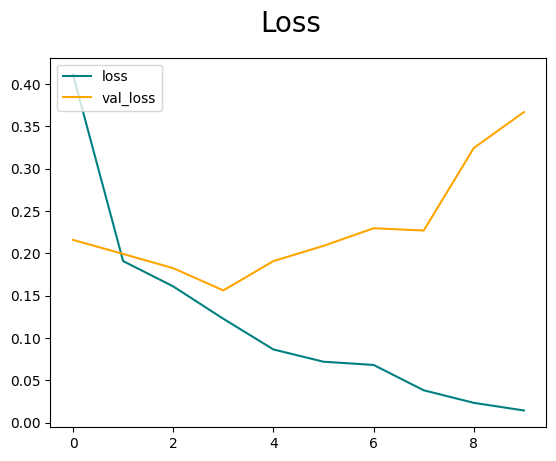

In [ ]:
# Loss metrics
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc='upper left')
plt.show()

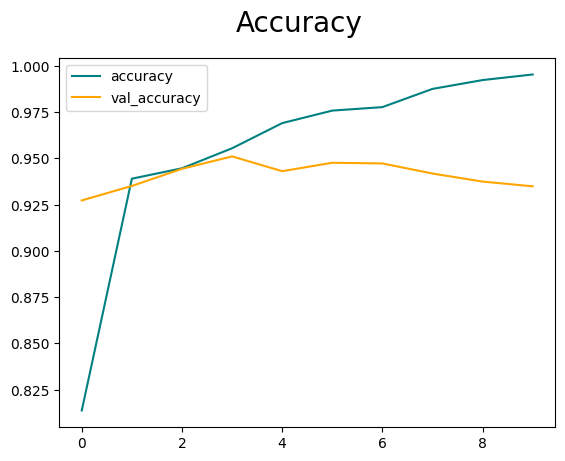

In [ ]:
# Accuracy metrics
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc='upper left')
plt.show()

# Evaluate Performance

Evaluation

In [ ]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [ ]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [ ]:
for batch in test.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

In [ ]:
print(f'Precision:{pre.result().numpy()}, Recall:{re.result().numpy()}, Accuracy:{acc.result().numpy}')

Precision:0.9368658661842346, Recall:0.9247032403945923, Accuracy:<bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=0.93266785>>


Testing the data

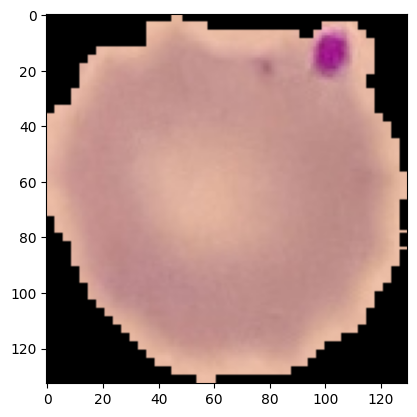

In [ ]:
img = cv2.imread(r'C:\Users\PC\Documents\Data-Science-Tasks\Malaria-ImageCLassification\models\Parasitized Test 1.png')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

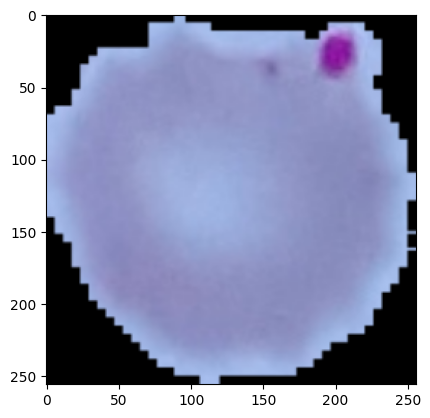

In [ ]:
resize_image = tf.image.resize(img, (256, 256))
plt.imshow(resize_image.numpy().astype(int))
plt.show()

In [ ]:
np.expand_dims(resize_image, 0)

array([[[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        ...,

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]]], dtype=float32)

In [ ]:
#Predict whether a pap smear is Uninfected or Parasitized.
# 1 = Uninfected and 0 = Parasitized
yhat = model.predict(np.expand_dims(resize_image/255, 0))
yhat

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step


array([[1.5942851e-18]], dtype=float32)

In [ ]:
if yhat > 0.5:
    print(f'Predicted class is Uninfected')
else:
    print(f'Predicted class is Parasitized')

Predicted class is Parasitized


# Save the Model

Saving the model, that I may be able to reload it at a future date

In [ ]:
from tensorflow.keras.models import load_model

In [ ]:
model.save(os.path.join('models','malariapapsmear.h5'))

In [ ]:
new_model = load_model(os.path.join('models','malariapapsmear.h5'))

In [ ]:
yhat_new=new_model.predict(np.expand_dims(resize_image/255, 0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step


In [ ]:
if yhat_new > 0.5:
    print(f'Predicted class is Uninfected')
else:
    print(f'Predicted class is Parasitized')

Predicted class is Parasitized
